## **Corn Yield Analysis: Modeling Yield from Nitrogen Fertilizer**

### Project Overview

In 1994, the relationship between corn yield (bushels per acre) and nitrogen (pounds per acre) fertilizer application was studied in Wisconsin. The data suggested a non-linear relationship where yield initially increases as nitrogen increases but eventually plateaus. The analysis here demonstrates how to identify and apply transformations to find a better predictive model, assess normality and variance assumptions, and use generalized least squares (GLS) with a compound symmetry correlation structure to address heteroscedasticity across different nitrogen treatment groups.

### Data and Initial Model


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse




,yield,nitrogen
,<int>,<int>
1,115,0
2,128,75
3,136,150
4,135,300
5,97,0
6,150,75


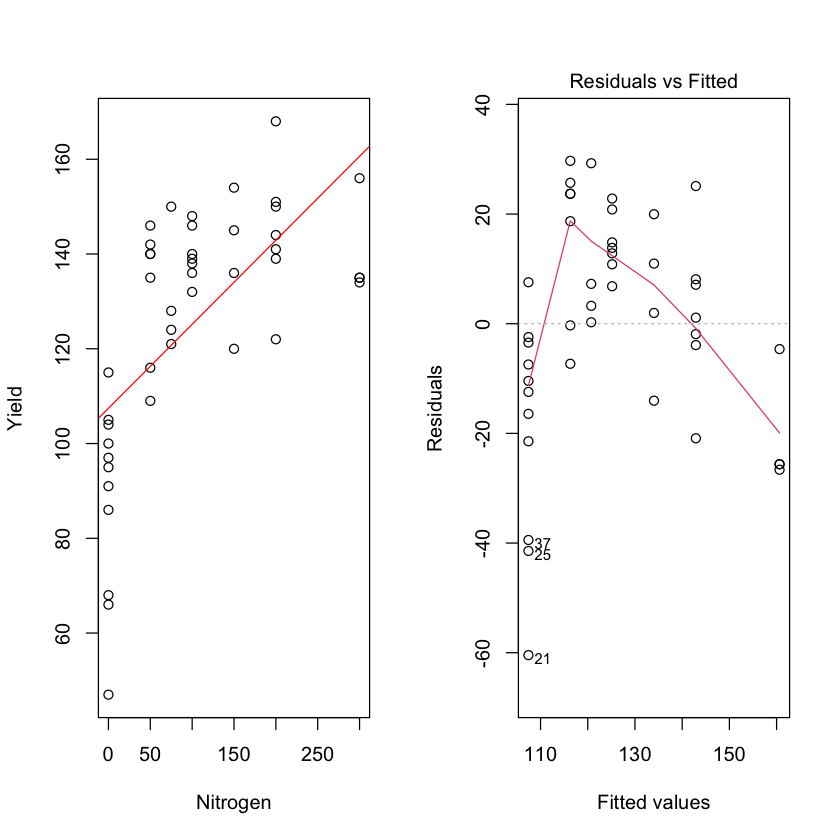

In [1]:
library(dplyr)
library(MASS)
library(nlme)
data(cornnit, package = "faraway")

head(cornnit)

lmod <- lm(yield ~ nitrogen, data = cornnit)

par(mfrow = c(1, 2))
plot(cornnit$nitrogen, cornnit$yield, xlab = "Nitrogen", ylab = "Yield")
abline(lmod, col = "red")
plot(lmod, which = 1)

Looking at the initial scatter plot, there appears to be a non-linear relationship between yield and nitrogen, with diminishing increases in yield at higher nitrogen levels. The residual plot also reveals heteroscedasticity (unequal variance) and signs of autocorrelation. To find the best transformation for the data, the Box-Cox method is employed. 

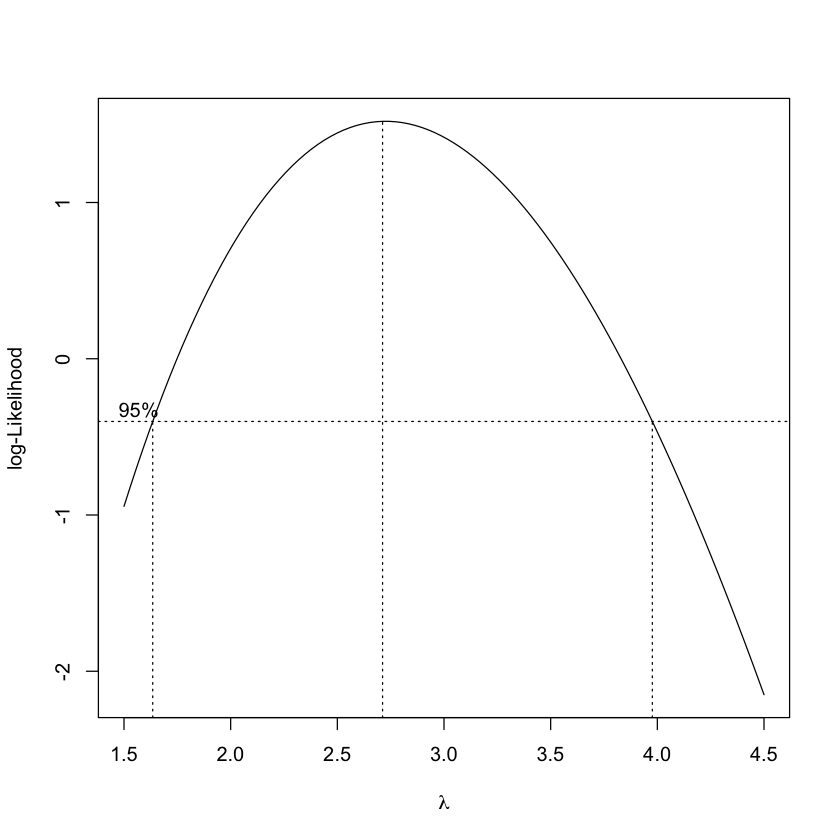

In [2]:
boxcox(lmod, lambda = seq(1.5, 4.5, by = 0.1))

The Box-Cox plot indicates a relatively high λ value, suggesting possible outliers. While an optimal λ of around 2.75 could be used, we also see λ=2 within the confidence interval, so either using \(y^2\) on the response or transforming the predictor by \(\sqrt{x}\) might be valid. However, a visual inspection suggests a log or square root transformation on the predictor is more intuitive.

### Testing Multiple Transformations

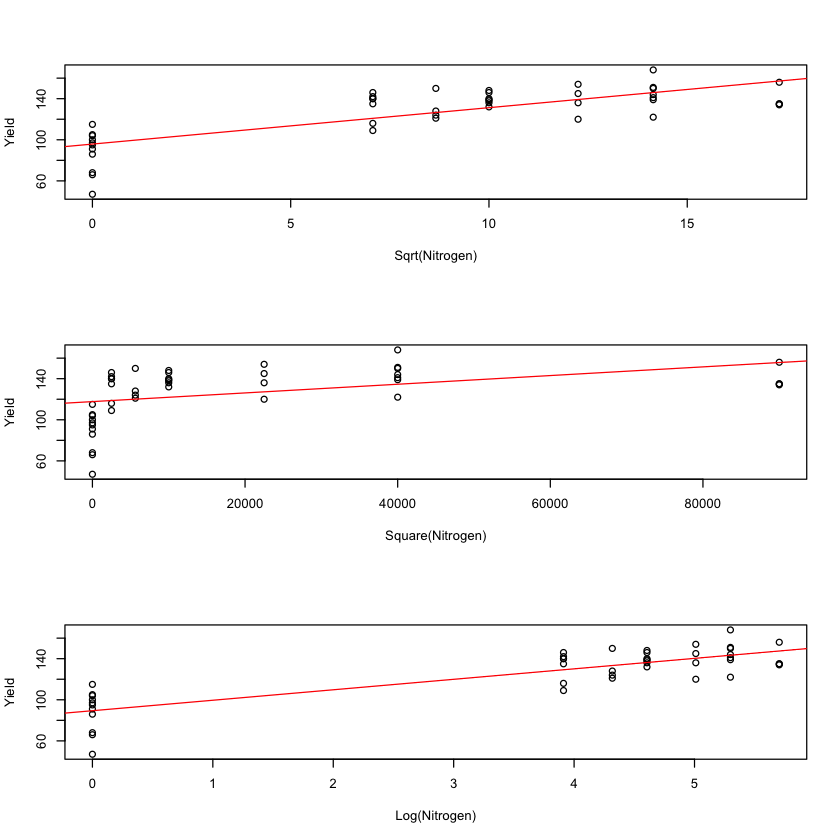

In [3]:
# Create data frames with transformed nitrogen variables
cornnit_sqrt <- cornnit
cornnit_sqrt$nitrogen <- sqrt(cornnit_sqrt$nitrogen)

cornnit_square <- cornnit
cornnit_square$nitrogen <- cornnit_square$nitrogen^2

# Adjust log transformation to handle 0 values
cornnit_log <- cornnit
cornnit_log$nitrogen <- ifelse(cornnit_log$nitrogen == 0, 1, cornnit_log$nitrogen)
cornnit_log$nitrogen <- log(cornnit_log$nitrogen)

# Fit models
lmod_sqrt <- lm(yield ~ nitrogen, data = cornnit_sqrt)
lmod_square <- lm(yield ~ nitrogen, data = cornnit_square)
lmod_log <- lm(yield ~ nitrogen, data = cornnit_log)

par(mfrow = c(3, 1))
plot(cornnit_sqrt$nitrogen, cornnit_sqrt$yield, xlab = "Sqrt(Nitrogen)", ylab = "Yield")
abline(lmod_sqrt, col = "red")

plot(cornnit_square$nitrogen, cornnit_square$yield, xlab = "Square(Nitrogen)", ylab = "Yield")
abline(lmod_square, col = "red")

plot(cornnit_log$nitrogen, cornnit_log$yield, xlab = "Log(Nitrogen)", ylab = "Yield")
abline(lmod_log, col = "red")

Both square root and log transformations are effective in linearizing the data, though log compresses the \(x\)-axis more. A residual analysis helps determine which yields the most stable variance:

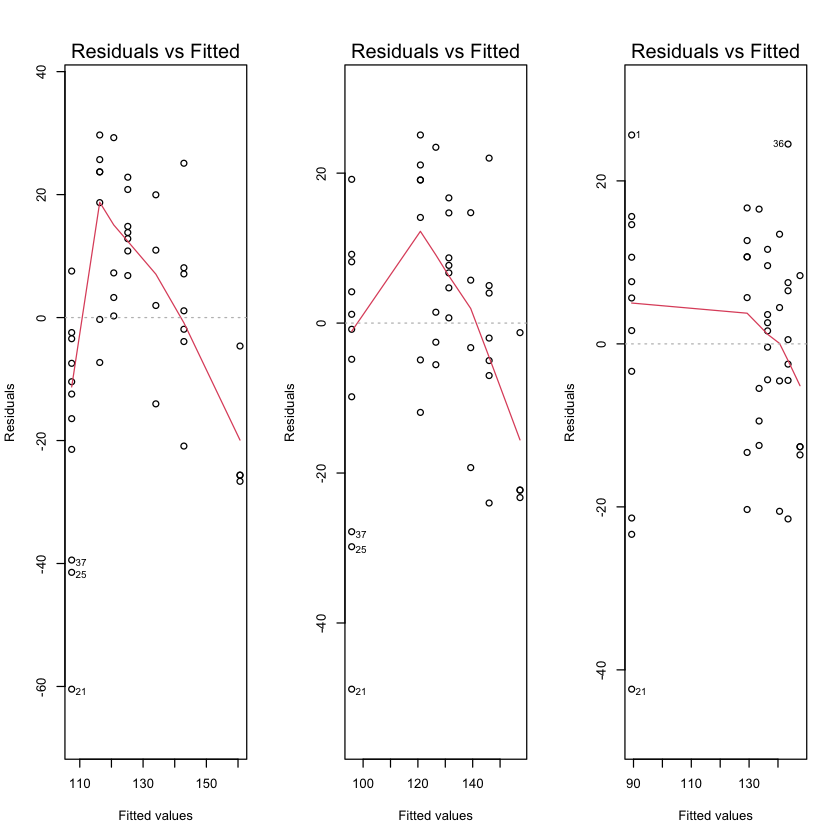

In [4]:
par(mfrow = c(1, 3))
plot(lmod, which = 1)
plot(lmod_sqrt, which = 1)
plot(lmod_log, which = 1)

The log transformation provides more equal variance with fewer signs of autocorrelation. Next, normality checks of the residuals:

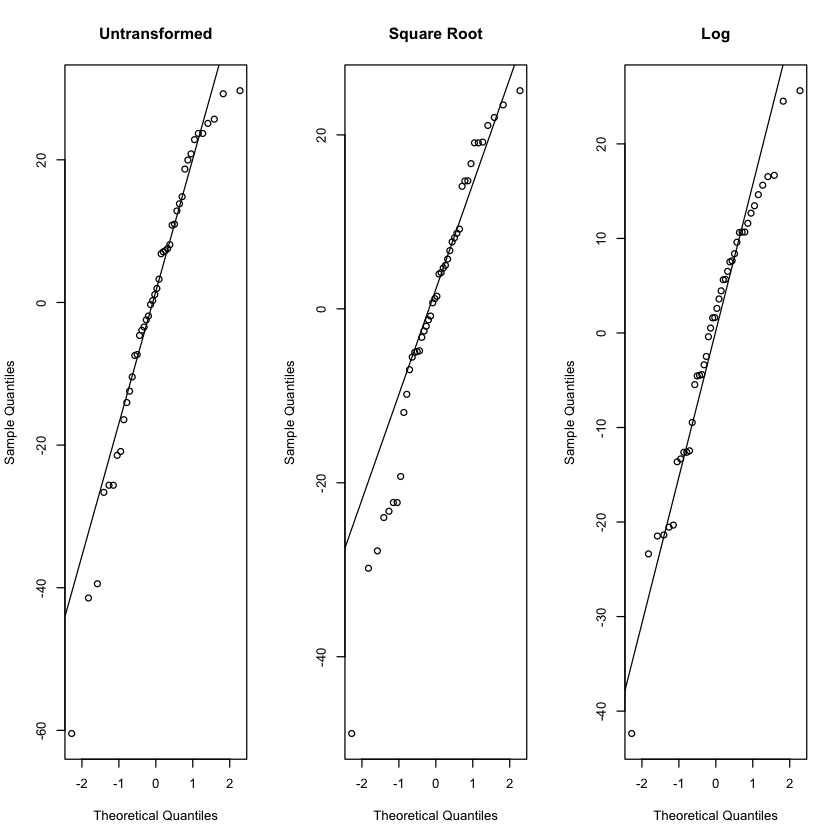

In [5]:
par(mfrow = c(1, 3))
qqnorm(residuals(lmod), main = "Untransformed")
qqline(residuals(lmod))

qqnorm(residuals(lmod_sqrt), main = "Square Root")
qqline(residuals(lmod_sqrt))

qqnorm(residuals(lmod_log), main = "Log")
qqline(residuals(lmod_log))

The square root transformation’s residuals diverge noticeably from normality; the log and the untransformed data are closer to normal. To formally assess normality:

In [6]:
shapiro.test(residuals(lmod))
shapiro.test(residuals(lmod_sqrt))
shapiro.test(residuals(lmod_log))


	Shapiro-Wilk normality test

data:  residuals(lmod)
W = 0.95164, p-value = 0.06332



	Shapiro-Wilk normality test

data:  residuals(lmod_sqrt)
W = 0.95054, p-value = 0.05765



	Shapiro-Wilk normality test

data:  residuals(lmod_log)
W = 0.96297, p-value = 0.1679


While none of the tests are significant (meaning we do not reject the null of normality), the largest W and p-values belong to the log model. Summaries of the models also show that the log transformation delivers the highest R-squared value and the lowest residual standard error:

In [7]:
summary(lmod)
summary(lmod_sqrt)
summary(lmod_log)


Call:
lm(formula = yield ~ nitrogen, data = cornnit)

Residuals:
    Min      1Q  Median      3Q     Max 
-60.439 -10.939   1.534  14.082  29.697 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 107.43864    4.66622   23.02  < 2e-16 ***
nitrogen      0.17730    0.03377    5.25 4.71e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.53 on 42 degrees of freedom
Multiple R-squared:  0.3962,	Adjusted R-squared:  0.3818 
F-statistic: 27.56 on 1 and 42 DF,  p-value: 4.713e-06



Call:
lm(formula = yield ~ nitrogen, data = cornnit_sqrt)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.827  -5.912   1.311  10.401  25.087 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   95.827      4.474  21.416  < 2e-16 ***
nitrogen       3.548      0.440   8.063 4.58e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.55 on 42 degrees of freedom
Multiple R-squared:  0.6075,	Adjusted R-squared:  0.5981 
F-statistic:    65 on 1 and 42 DF,  p-value: 4.577e-10



Call:
lm(formula = yield ~ nitrogen, data = cornnit_log)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.368 -10.214   2.115  10.643  25.632 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   89.368      4.227   21.14  < 2e-16 ***
nitrogen      10.213      1.019   10.02 1.05e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.34 on 42 degrees of freedom
Multiple R-squared:  0.7052,	Adjusted R-squared:  0.6982 
F-statistic: 100.5 on 1 and 42 DF,  p-value: 1.048e-12


Thus, a log transformation appears best for these data. However, there is likely some in-group correlation based on nitrogen levels, so the next step is to examine variance across these groups more carefully.

### Assessing Variance by Groups

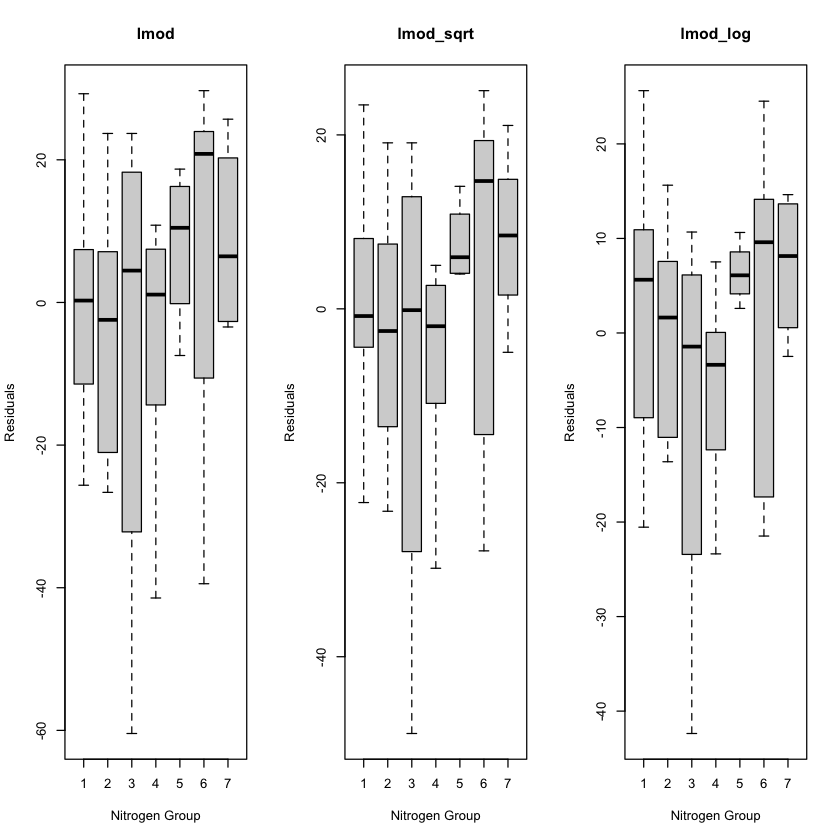

In [8]:
cornnit$nitrogen_group <- as.factor(as.numeric(factor(cornnit$nitrogen)))
cornnit <- cornnit[order(cornnit$nitrogen_group), ]
cornnit_orig <- cornnit

cornnit_orig$nitrogen_group <- as.factor(as.numeric(factor(cornnit_orig$nitrogen)))
cornnit_orig <- cornnit_orig[order(cornnit_orig$nitrogen_group), ]

cornnit_sqrt$nitrogen_group <- as.factor(as.numeric(factor(cornnit_sqrt$nitrogen)))
cornnit_sqrt <- cornnit_sqrt[order(cornnit_sqrt$nitrogen_group), ]

cornnit_log$nitrogen_group <- as.factor(as.numeric(factor(cornnit_log$nitrogen)))
cornnit_log <- cornnit_log[order(cornnit_log$nitrogen_group), ]

par(mfrow = c(1, 3))
plot(cornnit_orig$nitrogen_group, residuals(lmod), xlab = "Nitrogen Group", ylab = "Residuals", main = "lmod")
plot(cornnit_sqrt$nitrogen_group, residuals(lmod_sqrt), xlab = "Nitrogen Group", ylab = "Residuals", main = "lmod_sqrt")
plot(cornnit_log$nitrogen_group, residuals(lmod_log), xlab = "Nitrogen Group", ylab = "Residuals", main = "lmod_log")

There is noticeable unequal variance. A custom function performs pairwise variance tests between each nitrogen group to assess equality of variance:

In [9]:
# Function to perform pairwise variance tests
pairwise_variance_tests <- function(residuals, group) {
  results <- data.frame(Group1 = character(), Group2 = character(), 
                        F_statistic = numeric(), p_value = numeric())
  
  unique_groups <- unique(group)
  for (i in 1:(length(unique_groups) - 1)) {
    for (j in (i + 1):length(unique_groups)) {
      group1 <- unique_groups[i]
      group2 <- unique_groups[j]
      
      residuals_group1 <- residuals[group == group1]
      residuals_group2 <- residuals[group == group2]
      
      test_result <- var.test(residuals_group1, residuals_group2)
      
      results <- rbind(
        results, 
        data.frame(
          Group1 = as.character(group1), 
          Group2 = as.character(group2), 
          F_statistic = test_result$statistic, 
          p_value = test_result$p.value
        )
      )
    }
  }
  return(results)
}

residuals_lmod <- residuals(lmod)
lmod_results <- pairwise_variance_tests(residuals_lmod, cornnit_orig$nitrogen_group)

residuals_lmod_sqrt <- residuals(lmod_sqrt)
lmod_sqrt_results <- pairwise_variance_tests(residuals_lmod_sqrt, cornnit_sqrt$nitrogen_group)

residuals_lmod_log <- residuals(lmod_log)
lmod_log_results <- pairwise_variance_tests(residuals_lmod_log, cornnit_log$nitrogen_group)

mean_F_glmod <- mean(lmod_results$F_statistic)
mean_F_lmod_sqrt <- mean(lmod_sqrt_results$F_statistic)
mean_F_lmod_log <- mean(lmod_log_results$F_statistic)

print(paste("Mean F-Statistic for lmod:", mean_F_glmod))
print(paste("Mean F-Statistic for lmod_sqrt:", mean_F_lmod_sqrt))
print(paste("Mean F-Statistic for lmod_log:", mean_F_lmod_log))

[1] "Mean F-Statistic for lmod: 2.14591801686327"
[1] "Mean F-Statistic for lmod_sqrt: 4.62386201655294"
[1] "Mean F-Statistic for lmod_log: 5.98005870915253"


Interestingly, the log model shows the most unequal variance across groups despite being the best transformation overall. To correct this, the model can be fit using generalized least-squares (GLS) with a compound symmetry correlation structure, which can accommodate unequal variances across groups.

### Applying Generalized Least Squares (GLS)

In [10]:
head(cornnit_log)
glmod_log <- gls(yield ~ nitrogen, data = cornnit_log, 
                 correlation = corCompSymm(form = ~1 | nitrogen_group),
                 control = glsControl(apVar = TRUE))

summary(glmod_log)

,yield,nitrogen,nitrogen_group
,<int>,<dbl>,<fct>
1,115,0,1
5,97,0,1
9,95,0,1
13,91,0,1
17,105,0,1
21,47,0,1


Generalized least squares fit by REML
  Model: yield ~ nitrogen 
  Data: cornnit_log 
       AIC      BIC    logLik
  358.4228 365.3735 -175.2114

Correlation Structure: Compound symmetry
 Formula: ~1 | nitrogen_group 
 Parameter estimate(s):
 Rho 
-0.1 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 88.54545 0.0006666 132835.96       0
nitrogen    10.56096 0.3541439     29.82       0

 Correlation: 
         (Intr)
nitrogen 0     

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.9643790 -0.7771922  0.1524836  0.7235043  1.8876024 

Residual standard error: 14.01489 
Degrees of freedom: 44 total; 42 residual

The compound symmetry correlation structure explicitly models the potential correlation of measurements within the same group. Variance tests again:

In [11]:
glmod_log_results <- pairwise_variance_tests(residuals(glmod_log), cornnit_log$nitrogen_group)
mean_F_glmod_log <- mean(glmod_log_results$F_statistic)
print(paste("Mean F-Statistic for glmod_log:", mean_F_glmod_log))

[1] "Mean F-Statistic for glmod_log: 2.43144782036398"


The mean F-statistic drops significantly, indicating reduced variance discrepancies across groups. A direct comparison of overall and grouped variance:

In [12]:
residuals_glmod_log <- residuals(glmod_log)
residuals_lmod_log <- residuals(lmod_log)

var_residuals_glmod_log <- var(residuals_glmod_log)
var_residuals_lmod_log <- var(residuals_lmod_log)

cornnit_log$residuals_lmod_log <- residuals_lmod_log
cornnit_log$residuals_glmod_log <- residuals_glmod_log

variance_by_group_lmod <- cornnit_log %>%
  group_by(nitrogen_group) %>%
  summarize(var_residuals_lmod_log = var(residuals_lmod_log))

variance_by_group_glmod <- cornnit_log %>%
  group_by(nitrogen_group) %>%
  summarize(var_residuals_glmod_log = var(residuals_glmod_log))

variance_comparison <- merge(variance_by_group_lmod, variance_by_group_glmod, by = "nitrogen_group")
colnames(variance_comparison) <- c("nitrogen_group", "lmod_log", "glmod_log")

variance_ratio_lmod_log <- max(variance_comparison$lmod_log) / min(variance_comparison$lmod_log)
variance_ratio_glmod_log <- max(variance_comparison$glmod_log) / min(variance_comparison$glmod_log)

variance_comparison
print(paste("Overall Residual Variance for lmod_log:", var_residuals_lmod_log))
print(paste("Overall Residual Variance for glmod_log:", var_residuals_glmod_log))
print(paste("Variance Ratio for lmod_log:", variance_ratio_lmod_log))
print(paste("Variance Ratio for glmod_log:", variance_ratio_glmod_log))

nitrogen_group,lmod_log,glmod_log
<fct>,<dbl>,<dbl>
1,201.63079,412.27273
2,135.62808,202.61905
3,544.29081,172.91667
4,128.73200,30.80952
5,10.96353,210.25000
6,365.99274,195.33333
7,63.96518,114.00000


[1] "Overall Residual Variance for lmod_log: 200.989783881022"
[1] "Overall Residual Variance for glmod_log: 201.547068436064"
[1] "Variance Ratio for lmod_log: 49.6455651558849"
[1] "Variance Ratio for glmod_log: 13.3813404524378"


There is not a large change in the overall residual variance, but the variance ratio is greatly reduced. A Q-Q comparison shows how residual distribution changes with GLS:


	Shapiro-Wilk normality test

data:  residuals_glmod_log
W = 0.96795, p-value = 0.2556



	Shapiro-Wilk normality test

data:  residuals_lmod_log
W = 0.96297, p-value = 0.1679


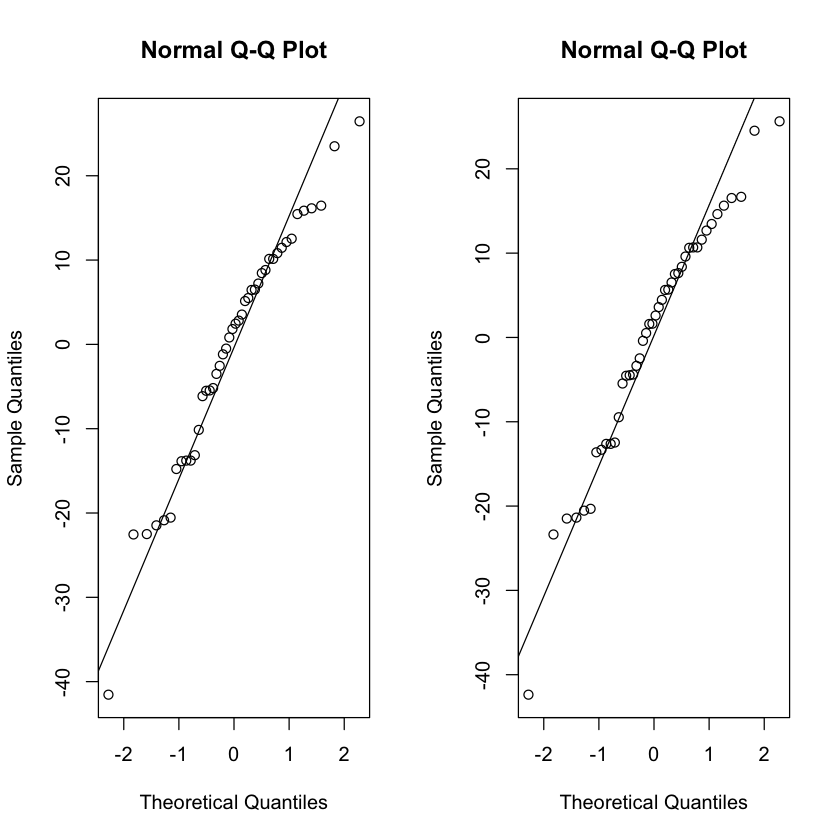

In [13]:
par(mfrow = c(1, 2))
qqnorm(residuals_glmod_log)
qqline(residuals_glmod_log)

qqnorm(residuals_lmod_log)
qqline(residuals_lmod_log)

shapiro.test(residuals_glmod_log)
shapiro.test(residuals_lmod_log)

We see slight improvements in the Q-Q plot and the Shapiro-Wilk statistic. A further check on the Rho parameter is done via bootstrapping:

In [14]:
library(boot)

boot_rho <- function(data, indices) {
  boot_data <- data[indices, ]
  tryCatch({
    mod <- gls(yield ~ nitrogen, 
               data = boot_data, 
               correlation = corCompSymm(form = ~1 | nitrogen_group),
               control = glsControl(maxIter = 100, opt = "optim"))
    coef(mod$modelStruct$corStruct, unconstrained = FALSE)
  }, error = function(e) NA)
}

set.seed(123)
boot_res <- boot(data = cornnit_log, statistic = boot_rho, R = 1000)
boot_values <- boot_res$t[!is.na(boot_res$t)]
ci <- quantile(boot_values, probs = c(0.025, 0.975))
print(paste("95% Confidence Interval:", round(ci[1], 4), "to", round(ci[2], 4)))

[1] "95% Confidence Interval: -0.1 to 0.2959"


The wide confidence interval for Rho includes 0, indicating weak in-group correlation despite improvements in variance equality. 

### Final Model Evaluation

A log transformation of the predictor variable effectively addresses non-linearity and stabilizes overall variance. However, noticeable heteroscedasticity across nitrogen groups remains. Introducing a compound symmetry correlation structure in a GLS model further reduces variance discrepancies, even though the Rho parameter is not significant. This indicates that while there is little actual correlation within groups, using GLS helps create a more stable variance structure across groups. By addressing heteroscedasticity, the GLS model provides more reliable inferences, including more accurate confidence intervals and p-values. In this case, its primary value is in mitigating unequal variances across groups rather than correcting strong within-group correlations.

---

**Key Takeaways**  
Transforming the data via the log of nitrogen helps linearize the relationship and improve model diagnostics overall. Residual plots, normality tests, and summary statistics indicate that a log transformation is preferable to square root or no transformation at all. Heteroscedasticity across different nitrogen application levels can be partially managed by applying a compound symmetry correlation structure in a GLS framework, improving variance equality even when there is no strong correlation within these groups. This approach enhances the robustness of statistical inferences and ensures more accurate model estimates for practical agricultural and environmental decision-making.